In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 3

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [3]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [4]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

468it [00:44, 10.61it/s]
468it [00:43, 10.81it/s]
468it [00:43, 10.76it/s]


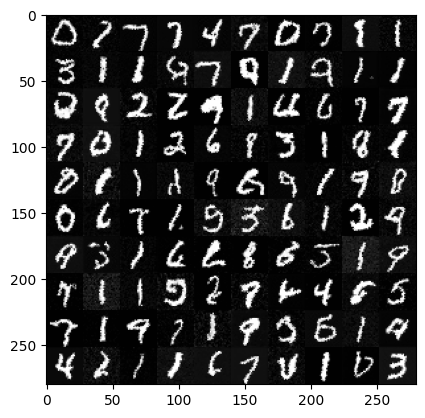

In [5]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28).to(device),
        t_span=torch.linspace(0, 1, 2).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [3]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1

# We note that with a little bit of effort these two networks can be combined to a single network with two prediction heads
# We leave it this way for simplicity in the notebook, but encourage you to consider supplying the `learn_sigma=True` parameter
# to the UNetModel, which outputs a shape (batch, 2, 28, 28), and can be used to increase efficiency.
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
score_model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [4]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, eps = FM.sample_location_and_conditional_flow(x0, x1, return_noise=True)
        lambda_t = FM.compute_lambda(t)
        vt = model(t, xt)
        st = score_model(t, xt)
        flow_loss = torch.mean((vt - ut) ** 2)
        score_loss = torch.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
        loss = flow_loss + score_loss
        loss.backward()
        optimizer.step()

468it [01:26,  5.43it/s]
468it [01:25,  5.45it/s]
468it [01:26,  5.42it/s]
468it [01:26,  5.42it/s]
468it [01:26,  5.41it/s]
468it [01:26,  5.41it/s]
468it [01:26,  5.41it/s]
468it [01:26,  5.41it/s]
468it [01:26,  5.42it/s]
468it [01:26,  5.41it/s]


/home/campus/kilian.fatras@MAIL.MCGILL.CA/anaconda3/envs/torchcfm2/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


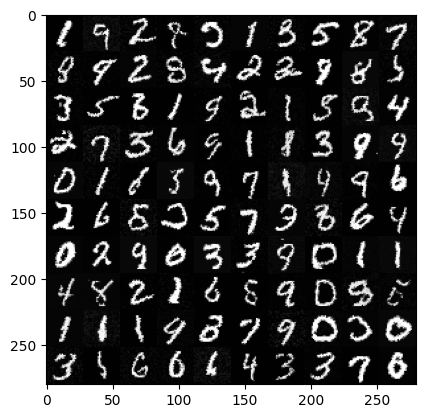

In [5]:
node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
# Evaluate the ODE
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28).to(device),
        t_span=torch.linspace(0, 1, 1000).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [9]:
# follows example from https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, reverse=False, sigma=0.1):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.reverse = reverse
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        y = y.view(-1, 1, 28, 28)
        if self.reverse:
            t = 1 - t
            return -self.drift(t, y) + self.score(t, y)
        return self.drift(t, y).flatten(start_dim=1) + self.score(t, y).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma

In [10]:
# from torchcfm.utils import SDE
sde = SDE(model, score_model, sigma=0.1)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        # x0.view(x0.size(0), -1),
        torch.randn(50, 1 * 28 * 28).to(device),
        ts=torch.linspace(0, 1, 2).to(device),
        dt=0.01,
    )

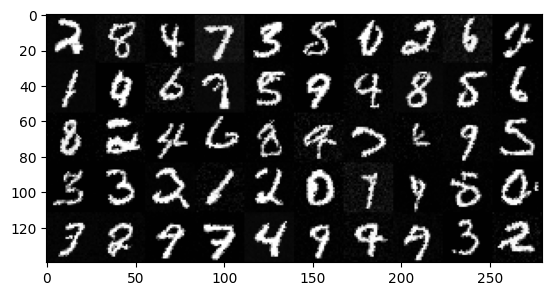

In [11]:
grid = make_grid(
    sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)